In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import re
from collections import namedtuple
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [72]:
N_WAVELENGTH = 228
LOD_HISTAMINE = 100
NAME_COLUMNS_HISTAMINE ='Histamine\n(mg/kg)'

In [73]:
df = pd.read_csv("data_NIRS/merged_db_Histamine.csv")

columns_wl = {}
for i, col in enumerate(df.columns[-N_WAVELENGTH:]):
    columns_wl[col] = str(i+1)
    
df.rename(columns=columns_wl, inplace=True)
df.head()

,Mã mẫu NIRS,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,Ngày đo,...,219,220,221,222,223,224,225,226,227,228
0,2231001a1,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",1,Hadamard 1,13/11/21,...,1.260815,1.255657,1.276434,1.322620,1.304198,1.285766,1.306818,1.267184,1.411523,1.352860
1,2231001a2,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",2,Hadamard 1,13/11/21,...,1.213489,1.231890,1.313393,1.314022,1.395009,1.452664,1.381067,1.484528,1.253933,1.233967
2,2231001a3,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",3,Hadamard 1,13/11/21,...,1.219571,1.272744,1.342526,1.342042,1.482628,1.419886,1.392945,1.367681,1.254773,1.268085
3,2231001a4,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",4,Hadamard 1,13/11/21,...,1.233272,1.338020,1.459565,1.392858,1.357045,1.388063,1.224139,1.248838,1.209269,1.289710
4,2231001a5,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",5,Hadamard 1,13/11/21,...,1.293733,1.310010,1.346611,1.232961,1.253616,1.209367,1.164405,1.251315,1.179963,1.086338


# Xử lý dữ liệu NaN và vô hạn

In [74]:
print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống trước xử lý: 2376
Tổng các điểm dữ liệu vô hạn trước xử lý: 9


In [75]:
# Lấy tất cả vị trí của các trị trống hoặc vô hạn
null_check = df.isna()
indices_null = np.argwhere(null_check.to_numpy() == True)

df_inf = df.iloc[:,-N_WAVELENGTH:]
inf_check = np.isinf(df_inf)
indices_inf = np.argwhere(inf_check.to_numpy()== True)
indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

indices = np.concatenate((indices_inf, indices_null))

In [76]:
n_nearest = 5 # Sử dụng n giá trị gần nhất cả 2 phía trước và sau để tính mean của missing data
for x,y in indices:
    if y < df.shape[1] - N_WAVELENGTH: # Chỉ xử lý các missing data của phổ
        continue
    #sample = df.iloc[x, np.maximum(y - n_nearest , 0):np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
    right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    sample = left.combine_first(right)
    df.iloc[x, y] = np.mean(sample)

In [77]:
print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


# Tạo test data từ dữ liệu gốc, tất cả các mẫu NIR của 1 con cá (thường là 60) thì sẽ nằm trong test data

In [9]:
def get_random_test_fish_id(df):
    TEST_SIZE = 0.2

    fish_numbers = df['STT mẫu cá'].unique()

    ure_value = []
    for number in fish_numbers:
        sub_df = df[df['STT mẫu cá'] == number]
        ure_value.append(sub_df[NAME_COLUMNS_HISTAMINE].iloc[1])
    y_labels = np.where(np.array(ure_value) >= LOD_HISTAMINE, 1, 0)

    number_test_fish = int(len(fish_numbers)*TEST_SIZE)

    indices_below_LOD = np.where(y_labels == 0)[0]
    test_indices_below_LOD = np.random.choice(indices_below_LOD, size=number_test_fish//2, replace=False)
    test_fish_numbers_below_LOD = fish_numbers[test_indices_below_LOD]

    indices_above_LOD = np.where(y_labels == 1)[0]
    test_indices_above_LOD = np.random.choice(indices_above_LOD, size=number_test_fish//2, replace=False)
    test_fish_numbers_above_LOD = fish_numbers[test_indices_above_LOD]

    test_fish_number = np.hstack((test_fish_numbers_above_LOD, test_fish_numbers_below_LOD))
    
    return test_fish_number

def train_smote_and_test_by_test_fish_id(df, test_id_fish:list):
    test_data = pd.DataFrame()
    train_data = df.copy()
    for i in test_id_fish:
        sub_df = df[df['STT mẫu cá'] == i]
        test_data = pd.concat([test_data, sub_df], axis=0)
        
        train_data = train_data.drop(train_data[train_data['STT mẫu cá'] == i].index)
        
    return train_data, test_data

def my_split_train_test(train_data, test_data):
    x_train = train_data.iloc[:,-N_WAVELENGTH:]
    y_train = np.where(train_data[NAME_COLUMNS_HISTAMINE] >= LOD_HISTAMINE, 1, 0)
    over_sample = SMOTE()
    x_train_smote, y_train_smote = over_sample.fit_resample(x_train, y_train)
    
    x_test = test_data.iloc[:,-N_WAVELENGTH:]
    y_test = np.where(test_data[NAME_COLUMNS_HISTAMINE] >= LOD_HISTAMINE, 1, 0)
    
    return x_train_smote, y_train_smote, x_test, y_test

In [10]:
test_fish_id = get_random_test_fish_id(df)
train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)

# Chia dữ liệu Train và trực quan trước khi SMOTE

In [78]:
X_TRAIN = train_data.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = np.where(train_data[NAME_COLUMNS_HISTAMINE] >= LOD_HISTAMINE, 1, 0)

# Tiền xử lý

Savizky-Golay 

In [79]:
def my_SG(X, deriv=0):
    X_SG = savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)
    return pd.DataFrame(X_SG)

In [80]:
def snv(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


In [81]:
def my_preprocess_data(X_data, feature='sg0', normalization = 'msc'):
    X_data_prep = X_data

    if normalization == 'msc':
        X_data_prep = msc(X_data)
    elif normalization == 'snv':
        X_data_prep = snv(X_data)
    elif normalization == 'minmax':
        X_data_prep = my_MinMaxScaler(X_data)
    elif normalization == 'robust':
        X_data_prep = my_RobustScaler(X_data)
        
    if feature == 'sg0':
        X_data_prep = my_SG(X_data_prep, 0)
    elif feature == 'sg1':
        X_data_prep = my_SG(X_data_prep, 1)
    elif feature == 'sg2':
        X_data_prep = my_SG(X_data_prep, 2)
    elif feature == 'sg1 + sg2':
        X_data_SG1 = my_SG(X_data_prep, 1)
        X_data_SG2 = my_SG(X_data_prep, 2)
        X_data_prep = np.hstack([X_data_SG1, X_data_SG2])
        
    return X_data_prep

# best K 

In [82]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def get_optimal_wavelength(X, y, top_n_features=10):
    best_features = SelectKBest(score_func=f_classif, k=top_n_features)
    fit = best_features.fit(X, y)

    return list(fit.get_feature_names_out())

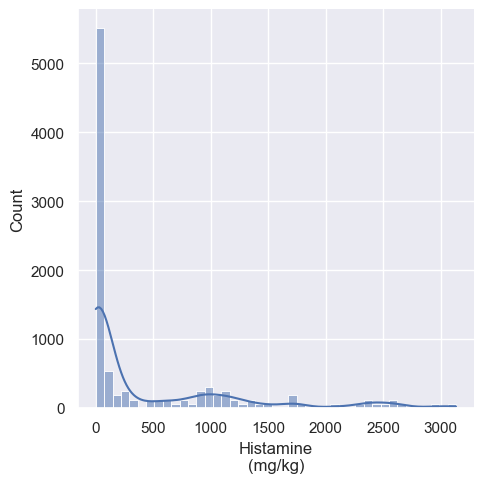

In [40]:

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(18.5,10.5)})
sns.displot(data=df,x=NAME_COLUMNS_HISTAMINE,kde=True)

In [58]:
from statistics import mean 
test_fish_id = get_random_test_fish_id(df)
train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)

X_TRAIN = train_data.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = train_data[NAME_COLUMNS_HISTAMINE] 

X_TEST = test_data.iloc[:,-N_WAVELENGTH:]
Y_TEST = test_data[NAME_COLUMNS_HISTAMINE]

Y_TEST_SNV = (Y_TEST - Y_TEST.mean()) / Y_TEST.std(ddof=0)
Y_TRAIN_SNV = (Y_TRAIN - Y_TRAIN.mean()) / Y_TRAIN.std(ddof=0)

print(f'{Y_TEST_SNV.mean()} {mean(Y_TEST_SNV)} + {Y_TEST_SNV.std(ddof=0)}')
print(f'{Y_TRAIN_SNV.mean()} {mean(Y_TRAIN_SNV)} + {Y_TRAIN_SNV.std(ddof=0)}')

-6.33352856387833e-17 -6.119369944225706e-17+ 1.0
-7.401486830834377e-17 -6.787105599759258e-17+ 1.0


In [88]:
print(f'{Y_TRAIN.mean()} + {Y_TRAIN.std(ddof=0)}')
print(f'{Y_TEST.mean()} + {Y_TEST.std(ddof=0)}')

0.375 + 0.4841229182759271
565.5795991410251 + 849.8900612945317


In [86]:
print(len(Y_TRAIN))
print(len(Y_TEST))

7680
1795


# PLSR

In [65]:
best_nc = 0
max_r2 = -1

for nc in range(3,30):
    pls = PLSRegression(n_components=nc)
    pls.fit(X_TRAIN, Y_TRAIN_SNV)
    y_pred = pls.predict(X_TEST)
    r2 = metrics.r2_score(Y_TEST_SNV, y_pred)
    if r2 > max_r2:
        max_r2 = r2
        best_nc = nc

print(max_r2, best_nc)

0.24269603190916278 29


In [66]:
pls = PLSRegression(n_components=best_nc)
pls.fit(X_TRAIN, Y_TRAIN_SNV)
y_pred = pls.predict(X_TEST)
mse = metrics.mean_squared_error(Y_TEST_SNV, y_pred)
r2 = metrics.r2_score(Y_TEST_SNV, y_pred)
mse, r2

(0.7573039680908372, 0.24269603190916278)

In [67]:
def my_plsr(X_train, y_train, X_test, y_test):
    pls = PLSRegression(n_components=best_nc)
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    mse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = metrics.r2_score(y_true=y_test, y_pred=y_pred, force_finite=False)
    return mse, r2

In [83]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc','snv', 'minmax', 'robust']

list_msc = []    
list_r2 = []  
for feature in all_feature_exaction:
    for normal in all_normalization:

        X_train = my_preprocess_data(X_TRAIN, feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST, feature=feature, normalization=normal)
        
        mse, r2 = my_plsr(X_train, Y_TRAIN_SNV, X_test, Y_TEST_SNV)
        list_msc.append(mse)
        list_r2.append(r2)
        print(mse, r2)

1.2323864113196974 -0.2323864113196974
0.7339693873753117 0.2660306126246883
0.6928300947499746 0.3071699052500254
0.7590778875295024 0.24092211247049755
0.783406797183954 0.216593202816046
0.7300393938769671 0.26996060612303285
0.6930168262471474 0.30698317375285256
0.7522937371647841 0.2477062628352159
0.7862449414748668 0.2137550585251332
0.7337507403674899 0.2662492596325101
0.6981069559602888 0.3018930440397112
0.7525415043182138 0.24745849568178624
0.7911648569182395 0.20883514308176054
0.7346035299757925 0.2653964700242075
0.6961206881445267 0.30387931185547334
0.7539796843532863 0.24602031564671367


In [84]:
print(min(list_msc), np.argmin(list_msc), max(list_r2), np.argmax(list_r2))

0.6928300947499746 2 0.3071699052500254 2


# Cross validation

In [32]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 5
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=1)
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df[NAME_COLUMNS_HISTAMINE].iloc[1])
    
y_labels = np.where(np.array(ure_value) >= LOD_HISTAMINE, 1, 0)

In [34]:
result_cv_position = {}

for times, (train_index, test_index) in enumerate(skf.split(ure_value, y_labels)):
    mse_each_position = []
    r2_each_position = []
    
    test_fish_id = fish_numbers[test_index]
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    x_train = train_data.iloc[:,-N_WAVELENGTH:]
    y_train = train_data[NAME_COLUMNS_HISTAMINE]
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_Y_TEST = sub_data_TEST[NAME_COLUMNS_HISTAMINE]
   
        X_train_pred = my_preprocess_data(x_train, feature='sg0', normalization='minmax')
        sub_X_test_pred = my_preprocess_data(sub_X_TEST, feature='sg0', normalization='minmax')
        
        y_train_prep = (y_train - y_train.mean()) / y_train.std(ddof=0)
        sub_y_test_prep = (sub_Y_TEST - sub_Y_TEST.mean()) / sub_Y_TEST.std(ddof=0)
        
        mse, r2 = my_plsr(X_train_pred, y_train_prep, sub_X_test_pred, sub_y_test_prep)
        
        print(f'Lần: {times+1},Vị trí : {position}, MSE : {mse}  ==>  R2: {r2}') 
        mse_each_position.append(mse)
        r2_each_position.append(r2)
        
    result_cv_position[times] = (mse_each_position, r2_each_position)
    print('='*30)

Lần: 1,Vị trí : Ngoài da, gáy, MSE : 0.9173938879757056  ==>  R2: 0.08260611202429458
Lần: 1,Vị trí : Ngoài da, lưng, MSE : 0.5708594479932548  ==>  R2: 0.4291405520067453
Lần: 1,Vị trí : Ngoài da, đuôi, MSE : 0.5464911040142181  ==>  R2: 0.45350889598578203
Lần: 1,Vị trí : Ngoài da, bụng, MSE : 0.6371230638501084  ==>  R2: 0.3628769361498917
Lần: 1,Vị trí : Mang 1, MSE : 0.7703188420120222  ==>  R2: 0.22968115798797795
Lần: 1,Vị trí : Mang 2, MSE : 0.7283467131409036  ==>  R2: 0.2716532868590965
Lần: 1,Vị trí : Mắt 1, MSE : 0.7148112744144555  ==>  R2: 0.28518872558554464
Lần: 1,Vị trí : Mắt 2, MSE : 0.8750979540951189  ==>  R2: 0.1249020459048813
Lần: 1,Vị trí : Trong thịt, gáy, MSE : 0.8355555443587699  ==>  R2: 0.16444445564123022
Lần: 1,Vị trí : Trong thịt, lưng, MSE : 0.8113403914025102  ==>  R2: 0.18865960859748987
Lần: 1,Vị trí : Trong thịt, đuôi, MSE : 0.828842434924699  ==>  R2: 0.17115756507530122
Lần: 1,Vị trí : Trong thịt, bụng, MSE : 0.8135105059539669  ==>  R2: 0.1864894

In [35]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_mse = []
    for j in range(K_FOLD):
        mse = result_cv_position[j][0][i]
        sub_list_mse.append(mse)
        
    sub_list_r2 = []
    for j in range(K_FOLD):
        r2 = result_cv_position[j][1][i]
        sub_list_r2.append(r2)
    print('Vị trí : {}  ==>  mse trung binh: {:.3f}, r2 trung binh: {:.3f}'.format(position, np.mean(sub_list_mse), np.mean(sub_list_r2)))

Vị trí : Ngoài da, gáy  ==>  mse trung binh: 0.749, r2 trung binh: 0.251
Vị trí : Ngoài da, lưng  ==>  mse trung binh: 0.631, r2 trung binh: 0.369
Vị trí : Ngoài da, đuôi  ==>  mse trung binh: 0.636, r2 trung binh: 0.364
Vị trí : Ngoài da, bụng  ==>  mse trung binh: 0.761, r2 trung binh: 0.239
Vị trí : Mang 1  ==>  mse trung binh: 0.809, r2 trung binh: 0.191
Vị trí : Mang 2  ==>  mse trung binh: 0.783, r2 trung binh: 0.217
Vị trí : Mắt 1  ==>  mse trung binh: 0.773, r2 trung binh: 0.227
Vị trí : Mắt 2  ==>  mse trung binh: 0.900, r2 trung binh: 0.100
Vị trí : Trong thịt, gáy  ==>  mse trung binh: 0.826, r2 trung binh: 0.174
Vị trí : Trong thịt, lưng  ==>  mse trung binh: 0.806, r2 trung binh: 0.194
Vị trí : Trong thịt, đuôi  ==>  mse trung binh: 0.813, r2 trung binh: 0.187
Vị trí : Trong thịt, bụng  ==>  mse trung binh: 0.823, r2 trung binh: 0.177


=====================================

In [83]:
result_cv_position2 = {}

for times, (train_index, test_index) in enumerate(skf.split(ure_value, y_labels)):
    mse_each_position = []
    r2_each_position = []
    
    test_fish_id = fish_numbers[test_index]
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    x_train = train_data.iloc[:,-N_WAVELENGTH:]
    y_train = np.log10(train_data['Urea'])
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_Y_TEST = np.log10(sub_data_TEST['Urea'])
   
        X_train_pred = my_preprocess_data(x_train, feature='sg0', normalization='minmax')
        sub_X_test_pred = my_preprocess_data(sub_X_TEST, feature='sg0', normalization='minmax')
        
        
        mse, r2 = my_plsr(X_train_pred, y_train, sub_X_test_pred, sub_Y_TEST)
        
        print(f'Lần: {times+1},Vị trí : {position}, MSE : {mse}  ==>  R2: {r2}') 
        mse_each_position.append(mse)
        r2_each_position.append(r2)
        
    result_cv_position2[times] = (mse_each_position, r2_each_position)
    print('='*30)

Lần: 1,Vị trí : Ngoài da, gáy, MSE : 0.4160619089504217  ==>  R2: 0.12907471463666542
Lần: 1,Vị trí : Ngoài da, lưng, MSE : 0.39838649835411577  ==>  R2: 0.16607392481751448
Lần: 1,Vị trí : Ngoài da, đuôi, MSE : 0.3657442474852368  ==>  R2: 0.23440260629810528
Lần: 1,Vị trí : Ngoài da, bụng, MSE : 0.3913263967691  ==>  R2: 0.1808525451510491
Lần: 1,Vị trí : Mang 1, MSE : 0.4864027353961197  ==>  R2: -0.018166844917425484
Lần: 1,Vị trí : Mang 2, MSE : 0.49082260839063113  ==>  R2: -0.02741878330977965
Lần: 1,Vị trí : Mắt 1, MSE : 0.5508234266560117  ==>  R2: -0.15301602892554467
Lần: 1,Vị trí : Mắt 2, MSE : 0.5053259099499101  ==>  R2: -0.05777794808189207
Lần: 1,Vị trí : Trong thịt, gáy, MSE : 0.4734594593721632  ==>  R2: 0.008926782550509715
Lần: 1,Vị trí : Trong thịt, lưng, MSE : 0.5079396873723435  ==>  R2: -0.038007701831097584
Lần: 1,Vị trí : Trong thịt, đuôi, MSE : 0.44534190183146044  ==>  R2: 0.08991493371869519
Lần: 1,Vị trí : Trong thịt, bụng, MSE : 0.4729255739702655  ==>  R

In [84]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_mse = []
    for j in range(K_FOLD):
        mse = result_cv_position2[j][0][i]
        sub_list_mse.append(mse)
        
    sub_list_r2 = []
    for j in range(K_FOLD):
        r2 = result_cv_position2[j][1][i]
        sub_list_r2.append(r2)
    print('Vị trí : {}  ==>  mse trung binh: {:.3f}, r2 trung binh: {:.3f}'.format(position, np.mean(sub_list_mse), np.mean(sub_list_r2)))

Vị trí : Ngoài da, gáy  ==>  mse trung binh: 0.396, r2 trung binh: 0.071
Vị trí : Ngoài da, lưng  ==>  mse trung binh: 0.378, r2 trung binh: 0.137
Vị trí : Ngoài da, đuôi  ==>  mse trung binh: 0.359, r2 trung binh: 0.175
Vị trí : Ngoài da, bụng  ==>  mse trung binh: 0.347, r2 trung binh: 0.194
Vị trí : Mang 1  ==>  mse trung binh: 0.436, r2 trung binh: -0.021
Vị trí : Mang 2  ==>  mse trung binh: 0.440, r2 trung binh: -0.019
Vị trí : Mắt 1  ==>  mse trung binh: 0.499, r2 trung binh: -0.169
Vị trí : Mắt 2  ==>  mse trung binh: 0.463, r2 trung binh: -0.093
Vị trí : Trong thịt, gáy  ==>  mse trung binh: 0.427, r2 trung binh: -0.002
Vị trí : Trong thịt, lưng  ==>  mse trung binh: 0.425, r2 trung binh: 0.021
Vị trí : Trong thịt, đuôi  ==>  mse trung binh: 0.416, r2 trung binh: 0.033
Vị trí : Trong thịt, bụng  ==>  mse trung binh: 0.417, r2 trung binh: 0.035
